# Hipótesis 4

Probando otros métodos para validar la hipótesis 4.

## Preparación del entorno

In [176]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score

GOLD_DATA_PATH = os.path.join("..", "..", "data/gold/")

## Datos mediana

Los datos que se usarán están en el dataset de la tarjeta de datos 4: `data_card_4_df.csv`. En los que se usa la mediana de la edad.

In [177]:
# Cargar de los datos
df4 = pd.read_csv(GOLD_DATA_PATH + "data_card_4_df.csv", sep=";", encoding = 'latin')


In [178]:
# Formateado de la tabla
df4 = df4.drop(columns=["Unnamed: 0"])
df4.set_index("Provincias", inplace=True)
df4.head(3)

,Porcentaje con dispositivo,Renta,Mediana edad,Producción media,Familia de 1 padres y 0 hijos,Familia de 1 padres y 1 hijos,Familia de 1 padres y 2 hijos,Familia de 2 padres y 0 hijos,Familia de 2 padres y 1 hijos,Familia de 2 padres y 2 hijos
Provincias,,,,,,,,,,
Albacete,4.314062,29549.0,47,136.528958,0.033132,0.072565,0.044648,0.356690,0.204834,0.288130
Alicante/Alacant,4.036060,27540.0,47,135.823750,0.041038,0.094143,0.045081,0.394342,0.197734,0.227663
Almería,6.713842,27301.0,42,140.478389,0.030276,0.090071,0.042470,0.349780,0.201309,0.286094


### Estandarización de los datos

Cada variable tiene una escala diferente, por lo que es necesario estandarizar los datos para que todas tengan la misma importancia en el análisis.
Se ha elegido el MinMaxScaler para que los valores estén entre 0 y 1, intentando modificar lo menos posible la distribución de los datos.


In [179]:
# Escalado de los datos a un rango de 0 a 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df4)
df4_scaled = pd.DataFrame(scaled_data, columns=df4.columns)

df4_scaled.head(3)

,Porcentaje con dispositivo,Renta,Mediana edad,Producción media,Familia de 1 padres y 0 hijos,Familia de 1 padres y 1 hijos,Familia de 1 padres y 2 hijos,Familia de 2 padres y 0 hijos,Familia de 2 padres y 1 hijos,Familia de 2 padres y 2 hijos
0,0.157519,0.226017,0.5,0.918039,0.171973,0.252788,0.614710,0.245278,0.422595,0.943885
1,0.128196,0.114808,0.5,0.903404,0.412220,0.630817,0.629123,0.506302,0.258196,0.550791
2,0.410642,0.101578,0.0,1.000000,0.085170,0.559481,0.542252,0.197373,0.340967,0.930649


### Análisis de componentes principales (PCA)

Para reducir la dimensionalidad de los datos y poder visualizarlos, se aplicará PCA. La representación se hará tanto en 2D como en 3D.

In [180]:
# Calculo de PCA
from sklearn.decomposition import PCA

estimator = PCA(n_components=3)
X_pca = estimator.fit_transform(scaled_data)

print("Porcentaje de varianza explicado por cada componente:\n", estimator.explained_variance_ratio_)
pd.DataFrame(np.matrix.transpose(estimator.components_), index=df4.columns)

Porcentaje de varianza explicado por cada componente:
 [0.47793154 0.17721048 0.10623954]


,0,1,2
Porcentaje con dispositivo,-0.207976,0.171516,-0.071669
Renta,-0.048365,0.548332,-0.132476
Mediana edad,0.567023,-0.260546,-0.354971
Producción media,-0.290303,-0.520709,0.078656
Familia de 1 padres y 0 hijos,0.356787,0.105319,0.142546
Familia de 1 padres y 1 hijos,0.179703,0.385980,0.341566
Familia de 1 padres y 2 hijos,-0.272816,0.345208,-0.064045
Familia de 2 padres y 0 hijos,0.332894,-0.025264,-0.244155
Familia de 2 padres y 1 hijos,0.119318,-0.152353,0.790839
Familia de 2 padres y 2 hijos,-0.435365,-0.166739,-0.137824


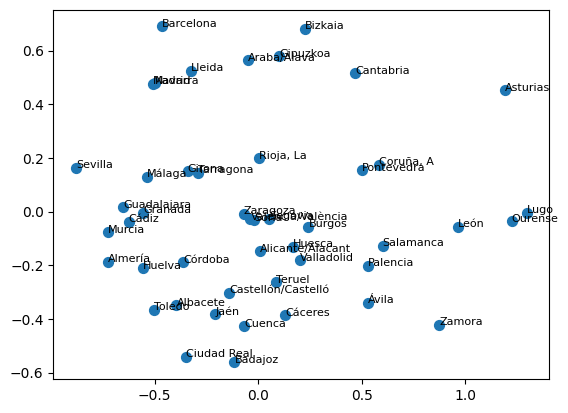

In [181]:
#Representación 2D
fig, ax = plt.subplots()
ax.scatter(X_pca[:,0], X_pca[:,1], s=50)

# anotación 
for i in range(0, len(X_pca)):
    ax.annotate(df4.iloc[i, :].name, (X_pca[i, 0], X_pca[i, 1]), fontsize=8)

In [182]:
# Representación 3D
import plotly.express as px

fig = px.scatter_3d(df4, x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2], color=df4.index, color_discrete_sequence=px.colors.qualitative.Alphabet)
fig.show()

## Modelado

### Clustering jerárquico

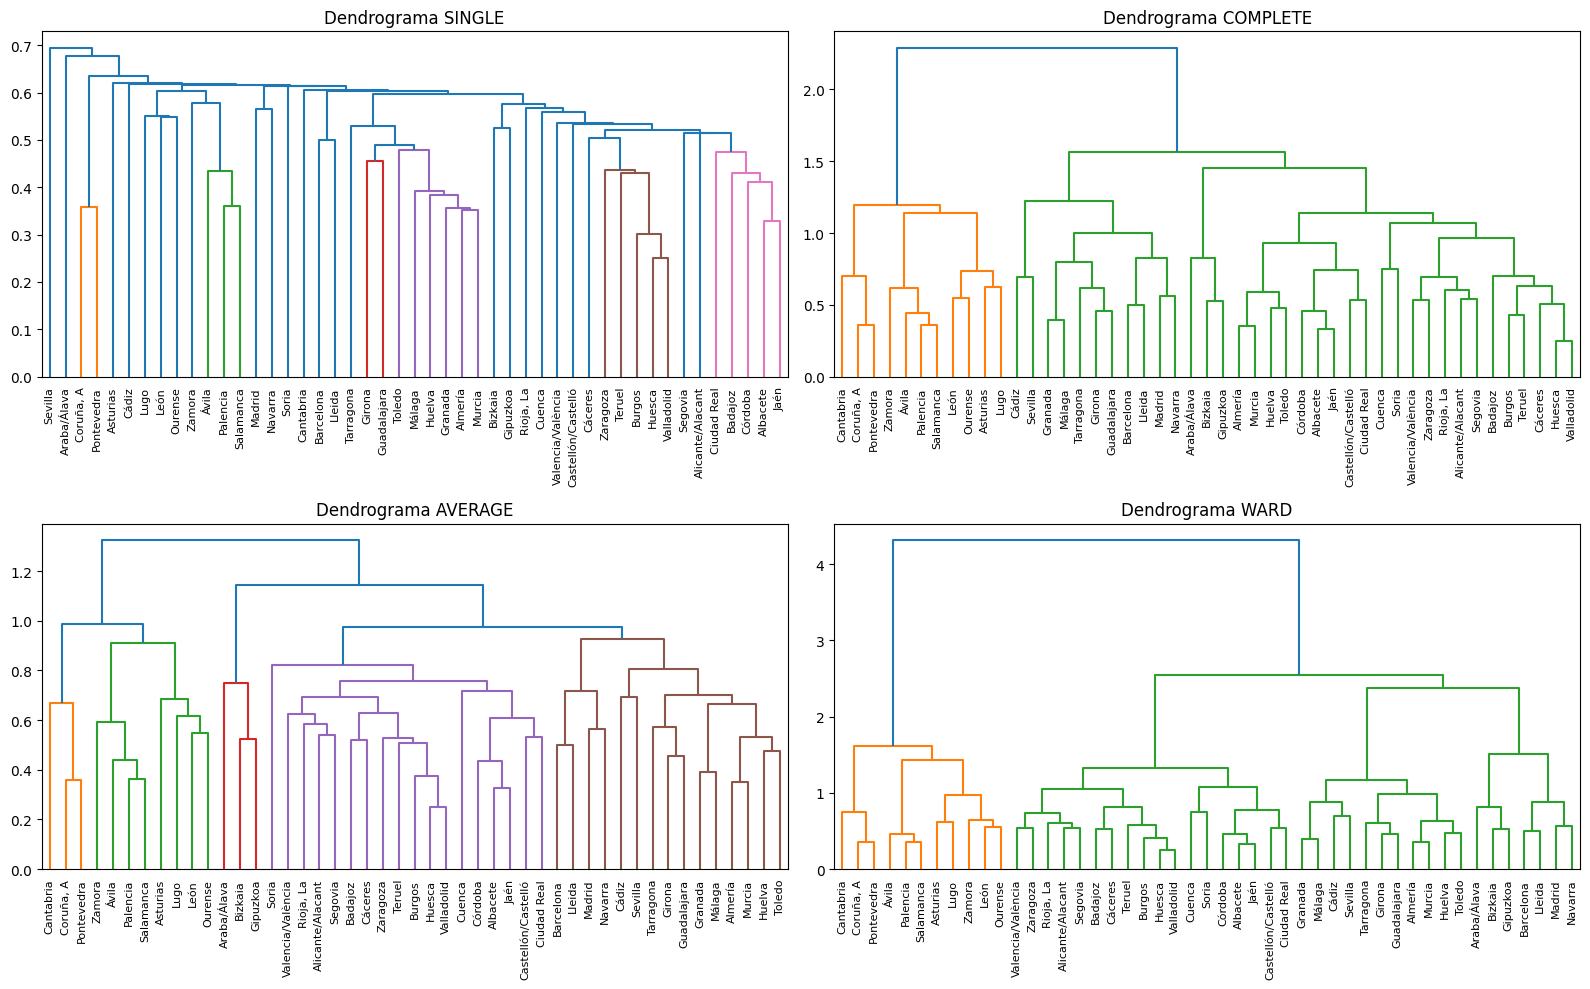

In [183]:
# Dendrograma probando con distintos métodos

methods = ['single', 'complete', 'average', 'ward']
plt.figure(figsize=(16, 10))
for method in methods:
    link_matrix = linkage(scaled_data, method=method, metric='euclidean')
    plt.subplot(2, 2, methods.index(method) + 1)
    dendrogram(link_matrix, labels=df4.index)
    plt.title('Dendrograma ' + method.upper())

plt.tight_layout()
plt.show()

El método ward es el que mejor se ajusta a los datos, por lo que se usará para el clustering jerárquico. Este método minimiza la distancia intra-cluster y maximiza la distancia inter-cluster.

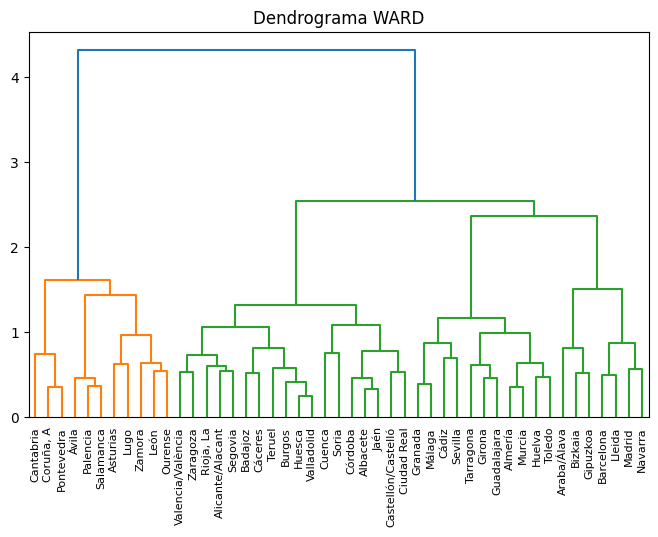

In [184]:
# Selección del método ward
link_matrix_avg = linkage(scaled_data, method='ward', metric='euclidean')

plt.figure(figsize=(8, 5))
dendrogram(link_matrix_avg, labels=df4.index)
plt.title('Dendrograma WARD')
plt.show()

In [185]:
# selección de número de clusters n = 2
n = 2
clusters = fcluster(link_matrix_avg, t=n, criterion='maxclust')
coef = silhouette_score(df4_scaled, clusters)
print(f"Coeficiente de silhouette para {n} clusters: {coef:.4f}")

Coeficiente de silhouette para 2 clusters: 0.3085


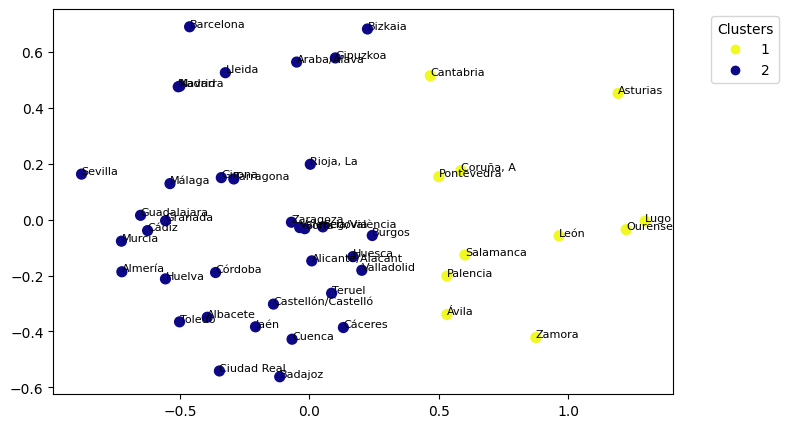

In [186]:
# visualización del resultado
plt.figure(figsize=(8, 5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], s=50, c=clusters, cmap='plasma_r')

# nombres de las provincias 
for i in range(0, len(X_pca)):
    plt.annotate(df4.iloc[i, :].name, (X_pca[i, 0], X_pca[i, 1]), fontsize=8)

handles, labels = scatter.legend_elements()
legend = plt.legend(handles, labels, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [187]:
import plotly.express as px

fig = px.scatter_3d(df4, x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2], color=clusters, color_continuous_scale='plasma_r')
fig.show()

## Resultados

Mapa de la península con las provincias coloreadas según el cluster al que pertenecen.   

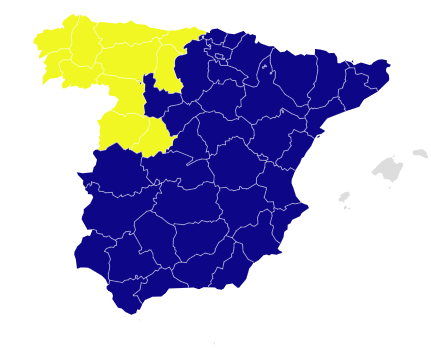

**Extra**

Este sería el resultado si se hubieran elegido 3 clusters. Es difícil interpretarlo, ya que ni siquiera coincide con los diferentes climas de la península ni con la división por ciudades más grandes.


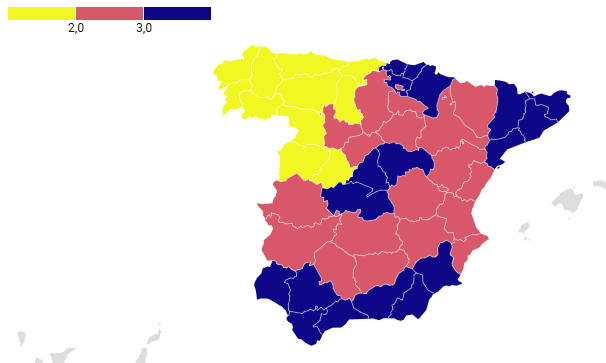

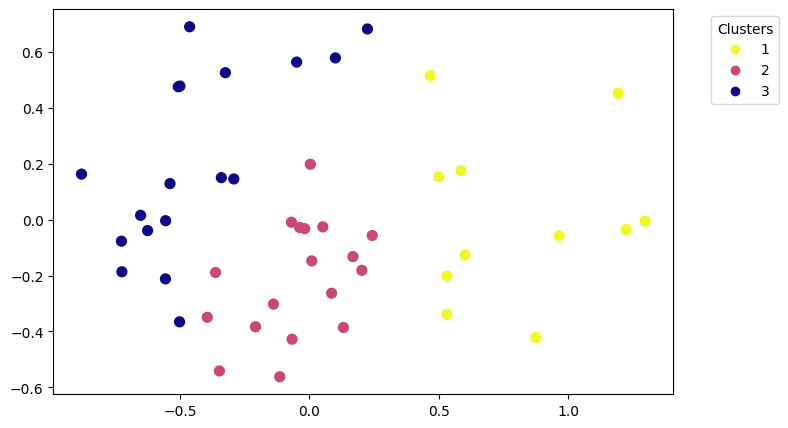

In [188]:
clusters = fcluster(link_matrix_avg, t=3, criterion='maxclust')

# visualización del resultado
plt.figure(figsize=(8, 5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], s=50, c=clusters, cmap='plasma_r')

handles, labels = scatter.legend_elements()
legend = plt.legend(handles, labels, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

----------------

## Datos K-Means

Usando la edad media.

In [189]:
# cargar los datos
df1 = pd.read_csv(GOLD_DATA_PATH + "data_card_1_df.csv", sep=";", encoding = 'latin')

df4 = pd.read_csv(GOLD_DATA_PATH + "data_card_4_df.csv", sep=";", encoding = 'latin')
df4.drop(columns=["Unnamed: 0"], inplace=True)

In [190]:
df4.drop(columns=["Mediana edad"], inplace=True)

In [191]:
# sustituir la variable edad
df4 = pd.concat([df4, df1['Edad media']], axis=1)
df4.set_index('Provincias', inplace=True)

In [192]:
df4.head()

,Porcentaje con dispositivo,Renta,Producción media,Familia de 1 padres y 0 hijos,Familia de 1 padres y 1 hijos,Familia de 1 padres y 2 hijos,Familia de 2 padres y 0 hijos,Familia de 2 padres y 1 hijos,Familia de 2 padres y 2 hijos,Edad media
Provincias,,,,,,,,,,
Albacete,4.314062,29549.0,136.528958,0.033132,0.072565,0.044648,0.356690,0.204834,0.288130,43.677523
Alicante/Alacant,4.036060,27540.0,135.823750,0.041038,0.094143,0.045081,0.394342,0.197734,0.227663,43.766889
Almería,6.713842,27301.0,140.478389,0.030276,0.090071,0.042470,0.349780,0.201309,0.286094,40.320448
Araba/Álava,10.445424,36848.0,107.768333,0.033775,0.097398,0.045232,0.401223,0.194786,0.227587,44.565691
Asturias,5.031368,31841.0,92.622917,0.056932,0.115216,0.035539,0.432127,0.211392,0.148794,48.683390


## Estandarización de los datos

Cada variable tiene una escala diferente, por lo que es necesario estandarizar los datos para que todas tengan la misma importancia en el análisis.
Se ha elegido el MinMaxScaler para que los valores estén entre 0 y 1, intentando modificar lo menos posible la distribución de los datos.

In [193]:
# Escalado de los datos a un rango de 0 a 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df4)
df4_scaled = pd.DataFrame(scaled_data, columns=df4.columns, index=df4.index)

df4_scaled.head(3)

,Porcentaje con dispositivo,Renta,Producción media,Familia de 1 padres y 0 hijos,Familia de 1 padres y 1 hijos,Familia de 1 padres y 2 hijos,Familia de 2 padres y 0 hijos,Familia de 2 padres y 1 hijos,Familia de 2 padres y 2 hijos,Edad media
Provincias,,,,,,,,,,
Albacete,0.157519,0.226017,0.918039,0.171973,0.252788,0.614710,0.245278,0.422595,0.943885,0.312311
Alicante/Alacant,0.128196,0.114808,0.903404,0.412220,0.630817,0.629123,0.506302,0.258196,0.550791,0.320625
Almería,0.410642,0.101578,1.000000,0.085170,0.559481,0.542252,0.197373,0.340967,0.930649,0.000000


## Análisis de componentes principales

Para reducir la dimensionalidad de los datos y poder visualizarlos, se aplicará PCA con 2 componentes.

In [194]:
# Calculo de PCA
from sklearn.decomposition import PCA

estimator = PCA(n_components=2)
X_pca = estimator.fit_transform(scaled_data)

print("Porcentaje de varianza explicado por cada componente:\n", estimator.explained_variance_ratio_)
pd.DataFrame(np.matrix.transpose(estimator.components_), index=df4.columns)

Porcentaje de varianza explicado por cada componente:
 [0.46993859 0.18378319]


,0,1
Porcentaje con dispositivo,0.205603,0.220431
Renta,0.008813,0.569415
Producción media,0.336520,-0.489870
Familia de 1 padres y 0 hijos,-0.390473,0.026589
Familia de 1 padres y 1 hijos,-0.226515,0.320956
Familia de 1 padres y 2 hijos,0.277720,0.429889
Familia de 2 padres y 0 hijos,-0.348278,-0.063164
Familia de 2 padres y 1 hijos,-0.137704,-0.273299
Familia de 2 padres y 2 hijos,0.478571,-0.072816
Edad media,-0.440690,-0.121222


Text(0.5, 1.0, 'Representación 2D de los datos')

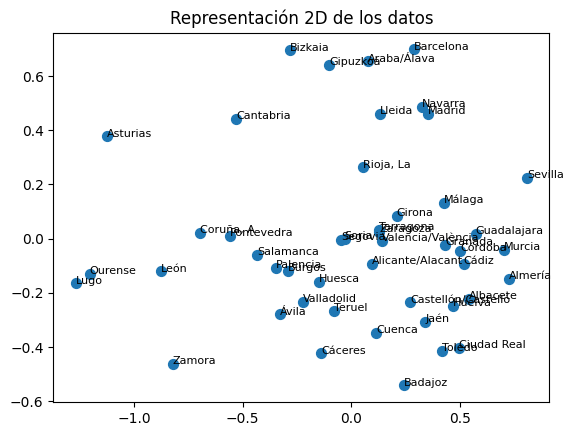

In [195]:
#Representación 2D
fig, ax = plt.subplots()
ax.scatter(X_pca[:,0], X_pca[:,1], s=50)

# anotación 
for i in range(0, len(X_pca)):
    ax.annotate(df4.iloc[i, :].name, (X_pca[i, 0], X_pca[i, 1]), fontsize=8)
ax.set_title("Representación 2D de los datos")

## Modelado

### K-means

El algoritmo de K-means es un algoritmo de clustering que divide los datos en K clusters. Se ha elegido K=2 para comparar los resultados con el clustering jerárquico. Para otro de los parámetros que es la inicialización de los centroides, se ha elegido el método k-means++, que es el que mejor se ajusta a los datos.

Primero se ha hecho una búsqueda de los mejores valores de K, con el método del codo.

In [196]:
from sklearn.cluster import KMeans
from sklearn import metrics

distortions = []
silhouettes = []
# visualizar diferentes configuraciones de k
for i in range(2, 11):
    km = KMeans(n_clusters = i, init = 'k-means++',random_state = 30)
    labels = km.fit_predict(X_pca)
    distortions.append(km.inertia_)
    silhouettes.append(metrics.silhouette_score(scaled_data, labels))

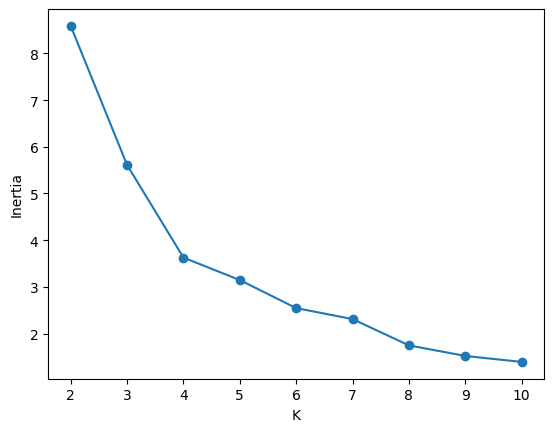

In [197]:
# distorsión de los clusters, visualizar el codo
plt.plot(range(2,11), distortions, marker='o')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()
# el k óptimo es 4

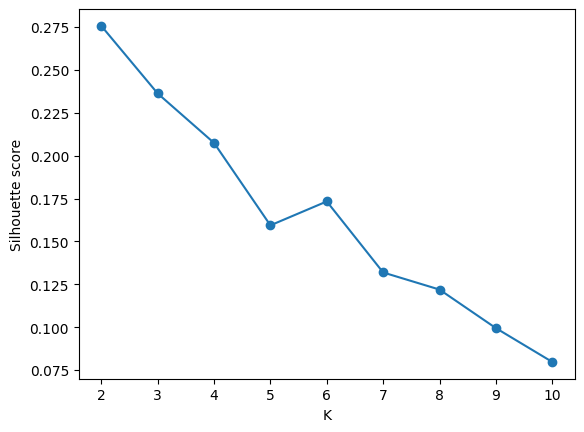

In [198]:
#plot Silhouette score
plt.plot(range(2,11), silhouettes, marker='o')
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.show()

Aunque k=2 no es el mejor valor, se ha elegido para comparar los resultados con el clustering jerárquico aunque el mejor valor sea k=4.

In [199]:
k = 2
km = KMeans(k, init = "k-means++", random_state = 30)

y_km = km.fit_predict(X_pca)

In [200]:
print("Coeficiente de Silhouette: ",silhouette_score(scaled_data, y_km))
print("Distorsión: ", km.inertia_)

Coeficiente de Silhouette:  0.2756609303476603
Distorsión:  8.589717874658024


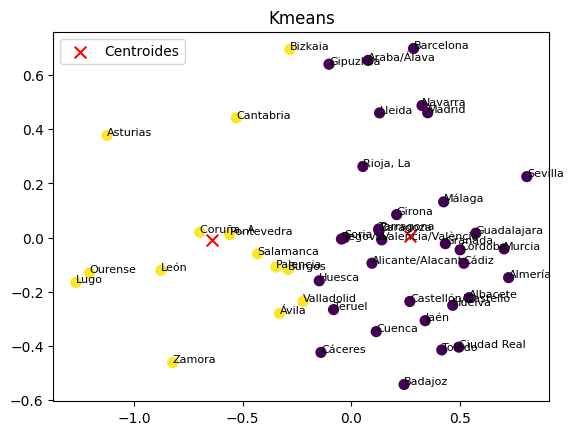

In [201]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_, s=50)
# Plot los centroides
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], c='red', s=70, marker='x', label='Centroides')

for i in range(len(X_pca)):
    plt.annotate(df4.iloc[i, :].name, (X_pca[i, 0], X_pca[i, 1]), fontsize=8)
plt.legend()
plt.title("Kmeans")
plt.show()

El algoritmo de KMeans simplemente ha dividido los datos en dos clusters por la mitad del gráfico. Al utilizar una agrupación esférica, es posible que no pueda separar los datos correctamente adaptándose para encontrar las mejores características. Dentro del cluster amarillo parece que provincias como Bizkaia, podría ser un outlier.Además, la selección del número de clusters no es la más adecuada, como se ha comprobado con el método del codo y el valor del coeficiente de Silhouette. 

**No utilizar este método para la hipótesis 4.**

## DBSCAN

Con DBSCAN buscamos obtener las provincias que sean outliers, es decir, que no pertenezcan a ningún cluster. 

In [202]:
from sklearn.metrics import DistanceMetric

# matriz de distancias euclídeas
dist = DistanceMetric.get_metric('euclidean')
matsim = dist.pairwise(scaled_data)

In [203]:
import math
minPtsA= int(math.log(len(df4_scaled))) # heurística minPts = ln(n)
minPtsB = int(df4_scaled.shape[1]+1) # heurística minPts = nº de dimensiones
print(f"Heuristica ln(n): {minPtsA} minPts\nHeurística nº dimensiones: {minPtsB} minPts")

Heuristica ln(n): 3 minPts
Heurística nº dimensiones: 11 minPts


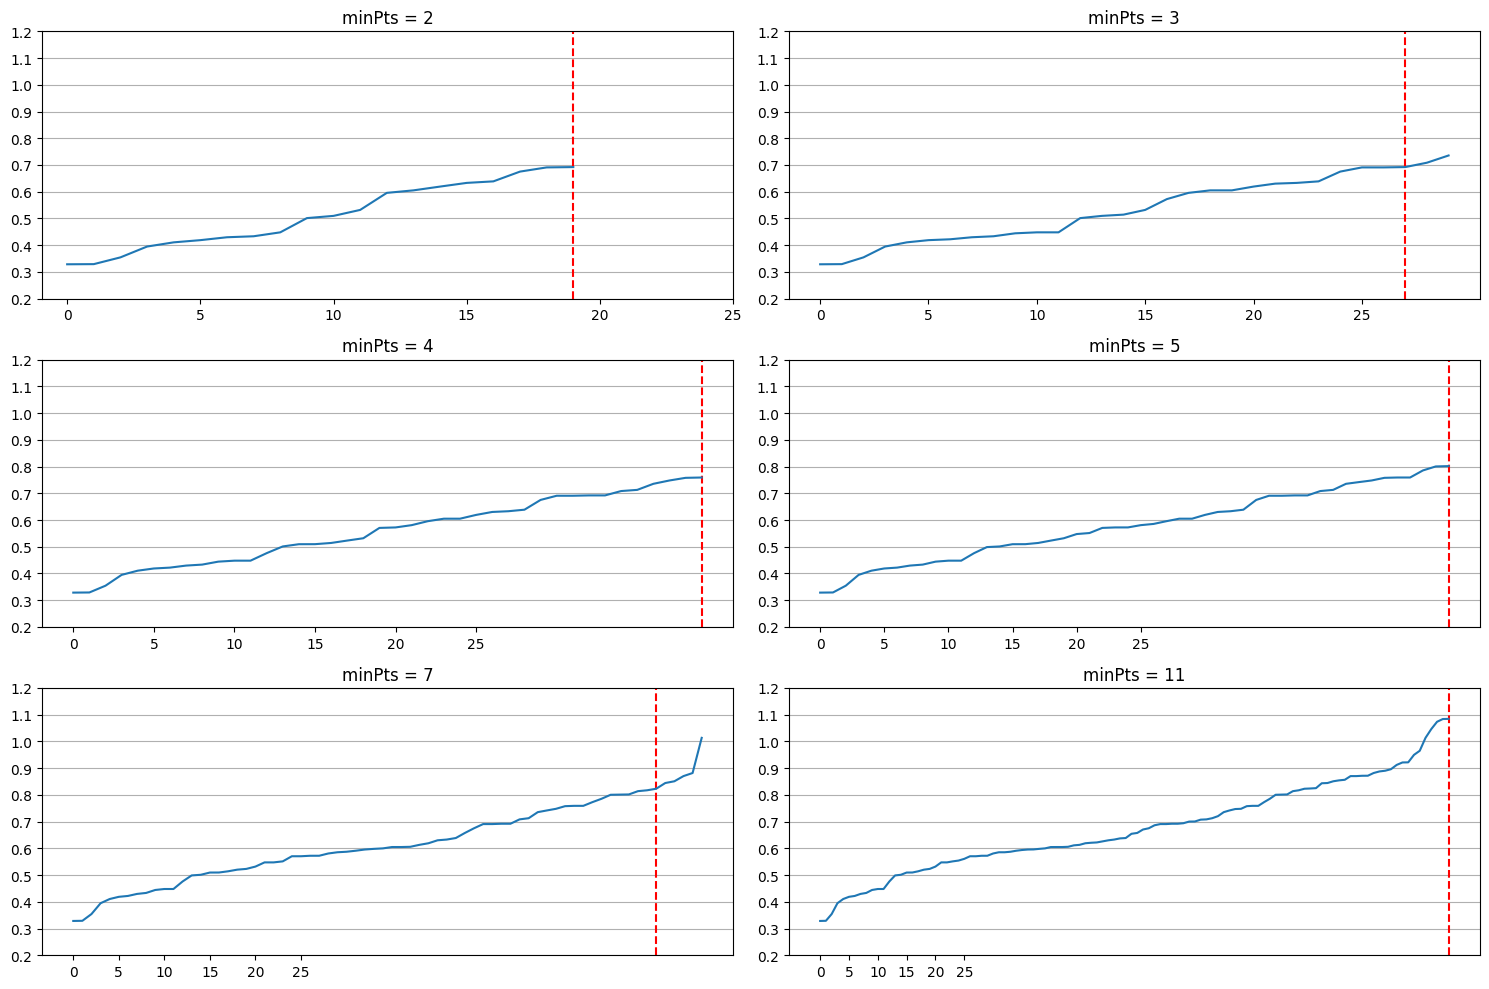

In [204]:
from sklearn.neighbors import kneighbors_graph
from kneed import KneeLocator

minPts_values = [2, 3, 4, 5, 7, 11]
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

for ax, minPts in zip(axes.flatten(), minPts_values):
    A = kneighbors_graph(df4_scaled, minPts, include_self=False)
    Ar = A.toarray()

    seq = []
    for i, s in enumerate(df4_scaled):
        for j in range(len(df4_scaled)):
            if Ar[i][j] != 0:
                seq.append(matsim[i][j])  # almacenar la distancia

    seq.sort()
    knee_locator = KneeLocator(range(len(seq)), seq, curve="convex", direction="increasing")
    ax.axvline(x=knee_locator.knee, color="r", linestyle="--", label=f"Codo en {knee_locator.knee}")
    ax.plot(seq)
    ax.set_title(f'minPts = {minPts}')
    ax.set_xticks(np.arange(0, 30, 5))
    ax.set_yticks(np.arange(0.2, 1.3, 0.1))
    ax.grid(axis='y')

plt.tight_layout()
plt.show()

La heurística A con el minPts = ln(samples) = 3, no tiene un codo claro, asi que hemos usado la librería kneed para encontrar el valor de eps. En la gráfica, la línea vertical roja, marca que el eps es 0.7, vamos a probar distintas distancias para ver aquellas que tengan un mejor resultado.

In [205]:
from sklearn.cluster import DBSCAN
import numpy as np
print ("eps    n_clusters  n_outliers")
for eps in np.arange(0.6, 0.8, 0.02):
  db = DBSCAN(eps, min_samples=3).fit(df4_scaled)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_outliers = list(labels).count(-1)
  print ("%.2f   %d           %d" % (eps, n_clusters_, n_outliers))

eps    n_clusters  n_outliers
0.60   2           13
0.62   2           7
0.64   1           2
0.66   1           2
0.68   1           1
0.70   1           0
0.72   1           0
0.74   1           0
0.76   1           0
0.78   1           0
0.80   1           0


Queremos hacer 2 clusters con el menor número de outliers posibles, por lo que seleccionaremos los siguientes parámetros para DBSCAN: 
* minPts = 3
* eps = 0.62

In [206]:
db = DBSCAN(eps=0.62, min_samples=3).fit(df4_scaled)

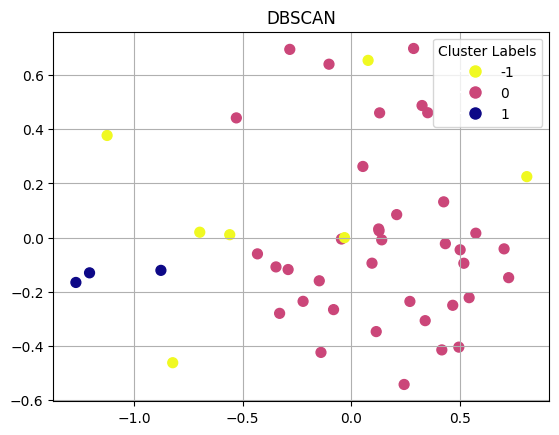

In [207]:
db = DBSCAN(eps=0.62, min_samples=3).fit(df4_scaled)
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=db.labels_, s=50, cmap='plasma_r')
plt.grid()

# Añadir la leyenda manualmente porque no mostraba el grupo -1
unique_labels = np.unique(db.labels_)
handles = []
for label in unique_labels:
    color = scatter.cmap(scatter.norm(label))  # Obtener el color correspondiente a cada etiqueta
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=str(label)))
plt.legend(handles=handles, title="Cluster Labels")

plt.title("DBSCAN")

plt.show()

La segunda heurística, que minPts = n + 1, en este caso son 11 puntos. No se tendrá en cuenta ya que el codo está al final de la gráfica.

------------

## Clasificación manual

In [208]:
norte=['Araba/Álava', 'Asturias', 'Barcelona', 'Bizkaia', 'Burgos', 'Cantabria', 'Coruña, A', 'Gipuzkoa', 'Girona', 'Guadalajara', 'Huesca', 'León', 'Lleida', 'Lugo', 'Navarra', 'Ourense', 'Palencia', 'Pontevedra', 'Rioja, La', 'Salamanca', 'Segovia', 'Soria', 'Tarragona', 'Teruel', 'Valladolid', 'Zamora', 'Zaragoza', 'Ávila']

df4['Grupo'] = ['Norte' if x in norte else 'Sur' for x in df4.index]

In [209]:
df4.head()

,Porcentaje con dispositivo,Renta,Producción media,Familia de 1 padres y 0 hijos,Familia de 1 padres y 1 hijos,Familia de 1 padres y 2 hijos,Familia de 2 padres y 0 hijos,Familia de 2 padres y 1 hijos,Familia de 2 padres y 2 hijos,Edad media,Grupo
Provincias,,,,,,,,,,,
Albacete,4.314062,29549.0,136.528958,0.033132,0.072565,0.044648,0.356690,0.204834,0.288130,43.677523,Sur
Alicante/Alacant,4.036060,27540.0,135.823750,0.041038,0.094143,0.045081,0.394342,0.197734,0.227663,43.766889,Sur
Almería,6.713842,27301.0,140.478389,0.030276,0.090071,0.042470,0.349780,0.201309,0.286094,40.320448,Sur
Araba/Álava,10.445424,36848.0,107.768333,0.033775,0.097398,0.045232,0.401223,0.194786,0.227587,44.565691,Norte
Asturias,5.031368,31841.0,92.622917,0.056932,0.115216,0.035539,0.432127,0.211392,0.148794,48.683390,Norte


In [210]:
df4.groupby('Grupo').mean()

,Porcentaje con dispositivo,Renta,Producción media,Familia de 1 padres y 0 hijos,Familia de 1 padres y 1 hijos,Familia de 1 padres y 2 hijos,Familia de 2 padres y 0 hijos,Familia de 2 padres y 1 hijos,Familia de 2 padres y 2 hijos,Edad media
Grupo,,,,,,,,,,
Norte,5.155543,33132.964286,118.608126,0.043806,0.092551,0.038844,0.401841,0.207682,0.215275,46.134766
Sur,5.732830,29330.842105,135.241652,0.035833,0.083094,0.042401,0.367766,0.205703,0.265203,43.108917
